# Removal of minimum mass cutoff

Searching for the bump without having the fairly arbitrary $25M_\odot$ cutoff in the earlier code. The plots of the mock data show that most of the simulated mergers have a "true" (source frame) mass around this 35$M_\odot$ bump, with a much smaller bump close to 10$M_\odot$. The logic of this was that the arbitrary cutoff, even if below the mass region of interest, messes up the KDE generation which could be causing the failure of the MCMC

In [1]:
import h5py
import pandas as pd
import glob
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as con
from astropy.cosmology import Planck18
from scipy.integrate import quad
from tqdm import tqdm
import warnings
from scipy import integrate
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')

%matplotlib inline

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
### Functions for implementing MCMC using PyMC4

def at_interp(x, xs, ys):
    '''Custom linear interpolator'''
    x  = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    n = xs.shape[0]
    
    ind = ate.searchsorted(xs, x)
    ind = at.where(ind >= n, n-1, ind)
    ind = at.where(ind < 0, 0, ind)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1]) 
    return r*ys[ind] + (1-r)*ys[ind-1]

def Ez(z, Om, w):
    opz = 1 + z
    return at.sqrt(Om*opz*opz*opz + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w)
    I = 0.5*dz*(fz[:-1] + fz[1:]) #trapazoidally integrating
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

def make_model(ms_obs, sigma_ms_obs, dls, zmax=100):
    zinterp = expm1(linspace(log(1), log(1+zmax), 1024))

    with pm.Model() as model:
        w = pm.Normal('w', mu=-1, sigma=0.25) 

        Om = pm.Bound('Om', pm.Normal.dist(mu=0.3, sigma=0.15), lower=0, upper=1)

        h = pm.Bound('h', pm.Lognormal.dist(mu=log(0.7), sigma=0.2), lower=0.35, upper=1.4)
#         h = pm.Lognormal('h', mu=log(0.7), sigma=0.2)
        Ode = pm.Deterministic('Ode', 1-Om)
        om = pm.Deterministic('om', Om*h*h)
        ode = pm.Deterministic('ode', Ode*h*h)

        dH= pm.Deterministic('dH', 2.99792/h)
        m0 = pm.Lognormal('m0', mu=log(35), sigma=0.5)

        dCinterp = dH*dCs(zinterp, Om, w)
        dLinterp = dLs(zinterp, dCinterp)
        
        zs = pm.Deterministic('zs', at_interp(dls, dLinterp, zinterp))

        pm.Normal('m_likelihood', mu=m0*(1+zs), sigma=sigma_ms_obs, observed=ms_obs)
    return model

def find_argmax_gridsearch(xs, fxs):
    imax = np.argmax(fxs)

    if imax == 0 or imax == len(xs)-1:
        warnings.warn('max occurs at grid boundary')
        return xs[imax]

    x0, x1, x2 = xs[imax-1], xs[imax], xs[imax+1]
    f0, f1, f2 = fxs[imax-1], fxs[imax], fxs[imax+1]

    dx01 = x0-x1
    dx12 = x1-x2
    dx20 = x2-x0

    sx01 = x0+x1
    sx12 = x1+x2
    sx20 = x2+x0

    xmax = (f2*dx01*sx01 + f0*dx12*sx12 + f1*dx20*sx20)/(2*(f2*dx01 + f0*dx12 + f1*dx20))

    return xmax


In [3]:
### Get m1_det and luminosity distances from data
f = "observations.h5"
n_mc = 20
n_dl = 10

with h5py.File(f, 'r') as hf:
    dl_max = np.max(hf['likelihood']['dl'])
    m_max = np.max(hf['likelihood']['m1_detector'])
    m_min = np.min(hf['likelihood']['m1_detector'])

    m1_det = np.array(hf['likelihood']['m1_detector'])
    dl = np.array(hf['likelihood']['dl'])

nevents, nsamples = dl.shape

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dl_cent = np.quantile(dl.flatten(), np.linspace(0.05, 0.95, n_dl))

DLG, MG = np.meshgrid(dl_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dl))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.94s/it]


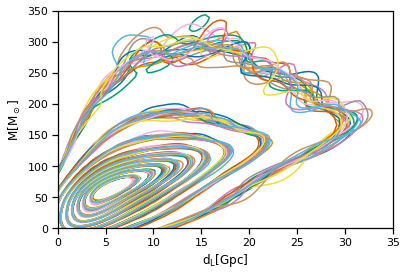

In [4]:
event_index_arr = np.arange(nevents)

for run in tqdm(range(n_mc)):
    sample_index_arr = np.random.randint(0, nsamples,  nevents)

    m = m1_det[event_index_arr, sample_index_arr]
    d = dl[event_index_arr, sample_index_arr]
    


    ### Set up KDE and pull out ridge

    arr = np.array([d, m])
    kde = gaussian_kde(arr)

    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    kplot = sns.kdeplot(x=d, y=m)
    kplot.set(xlim=(0, 35), ylim=(0,350), 
              ylabel=r"M[$\mathrm{M_\odot}$]", 
              xlabel=r"$\mathrm{d_L[Gpc]}$")
    for i in range(n_dl):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])

<AxesSubplot:ylabel='Density'>

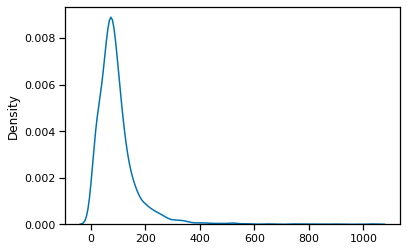

In [5]:
sns.kdeplot(m)

Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

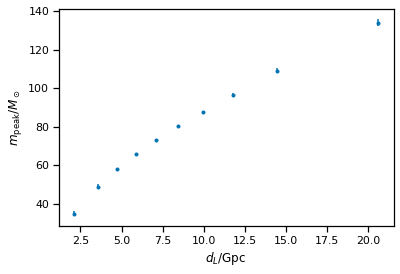

In [6]:
plt.errorbar(dl_cent, np.mean(mpeak_samples, axis=0), yerr=np.std(mpeak_samples, axis=0), fmt='.')
plt.xlabel(r'$d_L / \mathrm{Gpc}$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/home/tanner/.local/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
/home/tanner/.local/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.
There were 243 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5486, but should be close to 0.8. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


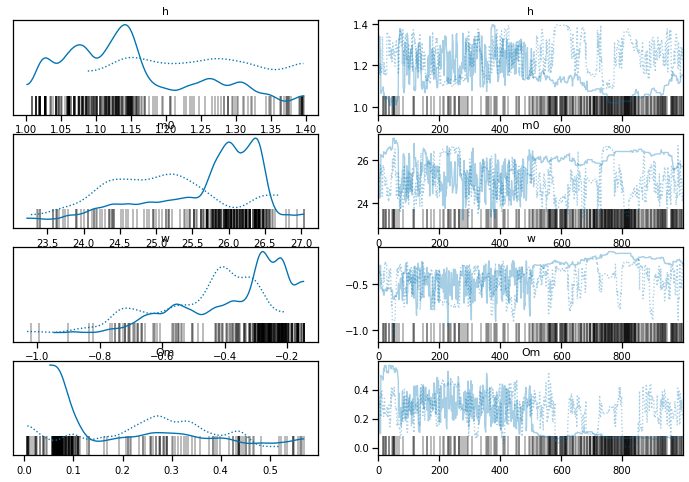

In [7]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = np.std(mpeak_samples, axis=0)

with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m, dls=dl_cent, zmax=10) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

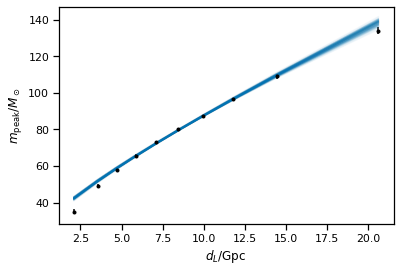

In [8]:
plt.errorbar(dl_cent, np.mean(mpeak_samples, axis=0), yerr=np.std(mpeak_samples, axis=0), fmt='.', color='k')

for _ in range(100):
    c = np.random.choice(trace.posterior.chain)
    d = np.random.choice(trace.posterior.draw)
    plt.plot(dl_cent, trace.posterior.m_peak.sel(chain=c, draw=d), color=sns.color_palette()[0], alpha=0.05)

plt.xlabel(r'$d_L / \mathrm{Gpc}$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')

In [9]:
cosmo = Planck18 # Planck+2018 cosmology
zmax = 3
z_range = np.linspace(0, zmax, 100)


In [10]:
def H(z, Ode, Om):
    epsilon = lambda x: (Om*(1+x)**3 + Ode)**-0.5
    return (1+z)*integrate.quad(epsilon, 0, z)[0]

Text(0, 0.5, '$\\mathrm{d_L/d_H}$')

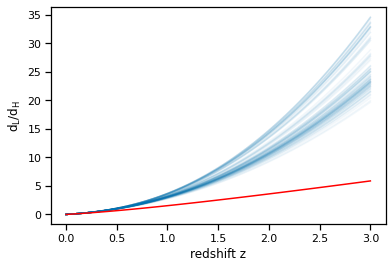

In [11]:
for _ in range(100):
    c = np.random.choice(trace.posterior.chain)
    d = np.random.choice(trace.posterior.draw)

    d_H = con.c/(100*u.km/u.s)*u.km/u.m/trace.posterior.h.sel(chain=c, draw=d).values
    Om = trace.posterior.Om.sel(chain=c, draw=d).values
    Ode = 1-Om

    Hz = [H(x, Ode, Om) for x in z_range]
    
    plt.plot(z_range, Hz*(1+z_range), color=sns.color_palette()[0], alpha=0.05)

plt.plot(z_range, cosmo.luminosity_distance(z_range)/cosmo.hubble_distance, 'r-')
plt.xlabel("redshift z")
plt.ylabel(r"$\mathrm{d_L/d_H}$")

The lowest end of the redshift range seems to be catching the 10$M_\odot$ bump as opposed to the 30$M_\odot$ one. Best guess is that that tiny bump around 10$M_\odot$ in the raw mock data is only tiny because they are not seen beyond a small distance out. They still dominate at these low redshifts and therefore the KDE is finding that ridge instead.

Breaking it apart now, redshift by redshift, to verify:

In [12]:
import matplotlib.colors as mcolors
cmap = list(mcolors.BASE_COLORS.keys())
print(len(cmap))

8


Text(0, 0.5, 'Probability Density [$\\mathrm{M_\\odot^{-1}}$]')

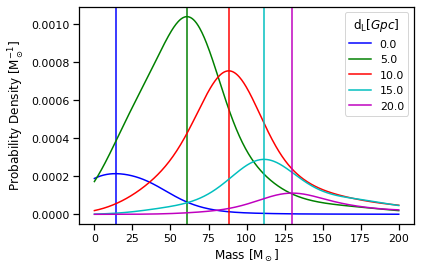

In [13]:
m_max = 200
dlim = 20

mass_indices = np.linspace(0, m_max, 400)

for j,d in enumerate(np.linspace(0, dlim, 5)):
    
    pdf = [kde.pdf([d, i]) for i in mass_indices]
    plt.plot(mass_indices, pdf,c=cmap[j], label=d)
    plt.axvline(mass_indices[np.argmax(pdf)], c=cmap[j])
    
plt.legend(title=r"$\mathrm{d_L}[Gpc]$")
plt.xlabel(r"Mass [$\mathrm{M_\odot}$]")
plt.ylabel(r"Probability Density [$\mathrm{M_\odot^{-1}}$]")

Looks like there's something there, let's zoom in a bit...

Text(0, 0.5, 'Probability Density [$\\mathrm{M_\\odot^{-1}}$]')

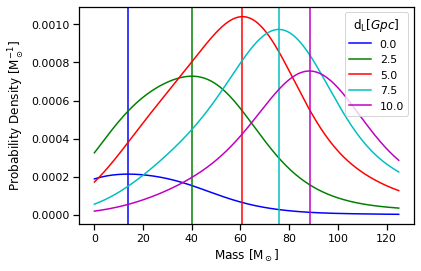

In [14]:
m_max = 125
dlim = 10

mass_indices = np.linspace(0, m_max, 400)

for j,d in enumerate(np.linspace(0, dlim, 5)):
    
    pdf = [kde.pdf([d, i]) for i in mass_indices]
    plt.plot(mass_indices, pdf,c=cmap[j], label=d)
    plt.axvline(mass_indices[np.argmax(pdf)], c=cmap[j])
    
plt.legend(title=r"$\mathrm{d_L}[Gpc]$")
plt.xlabel(r"Mass [$\mathrm{M_\odot}$]")
plt.ylabel(r"Probability Density [$\mathrm{M_\odot^{-1}}$]")

So that's definitely the issue here. It's fine at higher masses (probably, never actually calculated redshift) but it's definitely grabbing the low mass bump at low $d_L$

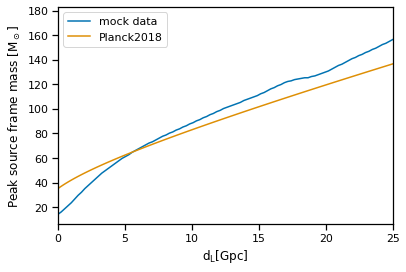

In [20]:
n_iter = 100
m_max = 200
zs = np.linspace(0, 4, n_iter)
max_masses = np.zeros(n_iter)
dls = np.linspace(0, 25, n_iter)
mass_indices = np.linspace(0, m_max, 400)

for j, d in enumerate(dls):
    
    pdf = [kde.pdf([d, m]) for m in mass_indices]
    max_masses[j] = mass_indices[np.argmax(pdf)]
    
plt.plot(dls, max_masses, label="mock data")
plt.plot(cosmo.luminosity_distance(zs)/1000, 35*(1+zs), label="Planck2018")
plt.xlabel(r"$\mathrm{d_L}$[Gpc]")
plt.xlim(min(dls), max(dls))
plt.ylabel(r"Peak source frame mass [$\mathrm{M_\odot}$]")
plt.legend()

That's looking pretty rough, not gonna lie. It's definitely snagging on the low mass bump at very low distances but quickly starts overshooting after 5 Gpc